In [1]:
import random

def generateData(machines=4, jobs=7, seed=0):
    PROC = [ [ 0 for m in range(machines) ] for j in range(jobs) ]
    random.seed(seed)
    for j in range(jobs):
        for m in range(machines):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [2]:
import pulp

def IP(PROC):

    steps = [ len(job) for job in PROC ]
    assert(min(steps)==max(steps))
    number_mach = len(PROC[0])
    number_jobs = len(PROC)


    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum( [ PROC[j][machine] * JJ[job][j] for j in range(number_jobs) ] ) 

    JJ = pulp.LpVariable.dicts("J", (range(number_jobs), range(number_jobs)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(number_jobs), range(number_mach)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(number_jobs), range(number_mach)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(number_jobs), range(number_mach)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(number_jobs), range(number_mach)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)
    prob += Stop[number_jobs-1][number_mach-1]

    # JJ is a permutation of the jobs
    for j in range(number_jobs):
        prob += pulp.lpSum( [ JJ[j][jj] for jj in range(number_jobs) ] ) == 1
        prob += pulp.lpSum( [ JJ[jj][j] for jj in range(number_jobs) ] ) == 1

    for m in range(number_mach):
        for j in range(number_jobs):
            prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

    for m in range(number_mach):
        for j in range(number_jobs):
            prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

    for j in range(number_jobs):
        for m in range(number_mach):
            prob += Start[j][m] + proc(j,m) == Stop[j][m]

    solvers = pulp.listSolvers(onlyAvailable=True) 
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    acc = []
    for j in range(number_jobs):
        for jj in range(number_jobs):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
                
    return acc, int(pulp.value(prob.objective))

In [3]:
import numpy as np

def totalTime(PROC, seq, log=False):
    
    def isPermutation(seq):
        for i in range(len(seq)):
            if i not in seq:
                return False
        return True
    
    steps = [ len(job) for job in PROC ]
    assert(len(PROC) == len(seq))
    assert(isPermutation(seq))
    assert(min(steps)==max(steps))
    number_mach = len(PROC[0])
    number_jobs = len(PROC)
    wait = np.zeros([number_jobs, number_mach], dtype=int)
    idle = np.zeros([number_jobs, number_mach], dtype=int)
    start = np.zeros([number_jobs, number_mach], dtype=int)
    stop  = np.zeros([number_jobs, number_mach], dtype=int)
    proc = np.zeros([number_jobs, number_mach], dtype=int)
    for job in range(number_jobs):
        proc[job] = PROC[seq[job]]
    for job in range(number_jobs):
        for machine in range(number_mach):
            start[job, machine] = max(stop[job-1, machine] if job>0 else 0, stop[job, machine-1] if machine>0 else 0)
            wait[job, machine] = start[job, machine] - (stop[job, machine-1] if machine>0 else 0)
            idle[job, machine] = start[job, machine] - (stop[job-1, machine] if job>0 else 0)
            stop[job, machine] = start[job, machine] + proc[job, machine]

    if log:

        row = '|---------|'
        for m in range(number_mach):
            row += f"------------|" \
                    f"------------|"
        print(row)
        
        row = '|         |'
        for m in range(number_mach):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        print(row)
        
        for j in range(number_jobs):
            
            row = '|---------|'
            for m in range(number_mach):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(number_mach):
                row += f"       {' ':4s} | " \
                       f"Idle: {idle[j,m]:4d} |"
            print(row)
            
            row = '|---------|'
            for m in range(number_mach):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(number_mach):
                row += f"       {' ':4s} | " \
                       f"Start:{start[j,m]:4d} |"  
            print(row)
            
            row = f'| Job: {seq[j]:2d} |'
            for m in range(number_mach):
                row += f" Wait: {wait[j,m]:4d} | " \
                       f"Proc: {proc[j,m]:4d} |"
            print(row)
            
            row = '|         |'
            for m in range(number_mach):
                row += f"       {' ':4s} | " \
                       f"Stop: {stop[j,m]:4d} |"  
            print(row)
            
        row = '|---------|'
        for m in range(number_mach):
            row += f"------------|" \
                    f"------------|"
        print(row)

    
    return stop[number_jobs-1, number_mach-1]                                                       

In [17]:
PROC = generateData(machines=4, jobs=7, seed=1899)

In [18]:
PROC

[[3, 1, 4, 5],
 [2, 4, 9, 3],
 [2, 8, 8, 4],
 [2, 5, 3, 3],
 [8, 1, 7, 4],
 [2, 3, 3, 8],
 [5, 8, 3, 7]]

Compute the optimal job schedule:

In [19]:
seq, proctime = IP(PROC)
print(seq)
print(proctime)

[5, 0, 1, 3, 6, 4, 2]
46


Check the processing time and print the schedule

In [20]:
ip_time = totalTime(PROC, seq)

print(f'IP time: {ip_time}')

IP time: 46


In [21]:
totalTime(PROC, seq, log=True)

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    2 |            | Idle:    5 |            | Idle:    8 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   2 |            | Start:   5 |            | Start:   8 |
| Job:  5 | Wait:    0 | Proc:    2 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    8 |
|         |            | Stop:    2 |            | Stop:    5 |            | Stop:    8 |            | Stop:   16 |
|---------|------------|------------|------------|------------|---------

46

# Greedy Algorithm

In [22]:
def greedy_algorithm(PROC):

    number_jobs = len(PROC)
    job_order = sorted(range(number_jobs), key=lambda j: sum(PROC[j]))
    
    return job_order

# Genetic Algorithm

In [23]:
import random

def genetic_algorithm(PROC, population_size=100, generations=500, mutation_rate=0.1):
    number_jobs = len(PROC)
    
    def create_individual():
        return random.sample(range(number_jobs), number_jobs)
    
    def crossover(parent1, parent2):
        crossover_point = random.randint(1, number_jobs-2)
        child1 = parent1[:crossover_point] + [job for job in parent2 if job not in parent1[:crossover_point]]
        child2 = parent2[:crossover_point] + [job for job in parent1 if job not in parent2[:crossover_point]]
        return child1, child2
    
    def mutate(individual):
        i, j = random.sample(range(number_jobs), 2)
        individual[i], individual[j] = individual[j], individual[i]
    
    def fitness(individual):
        return totalTime(PROC, individual)
    
    population = [create_individual() for _ in range(population_size)]
    
    for _ in range(generations):

        population = sorted(population, key=fitness)
        
        next_generation = population[:population_size//2] 
        
        for i in range(0, len(next_generation), 2):
            if i+1 < len(next_generation):
                child1, child2 = crossover(next_generation[i], next_generation[i+1])
                next_generation.append(child1)
                next_generation.append(child2)
        
        for individual in next_generation[1:]: 
            if random.random() < mutation_rate:
                mutate(individual)
        
        population = next_generation[:population_size]
    
    best_individual = min(population, key=fitness)
    return best_individual

In [32]:
# Implementing Greedy Algorithm
greedy_schedule = greedy_algorithm(PROC)
print("Greedy Algorithm Schedule : ", greedy_schedule)
greedy_time = totalTime(PROC, greedy_schedule)
print("Total Time (Greedy):", greedy_time)

# Implementing Genetic Algorithm
genetic_schedule = genetic_algorithm(PROC)
print("Genetic Algorithm Schedule : ", genetic_schedule)
genetic_time = totalTime(PROC, genetic_schedule)
print("Total Time (Genetic):", genetic_time)


Greedy Algorithm Schedule :  [0, 3, 5, 1, 4, 2, 6]
Total Time (Greedy): 52
Genetic Algorithm Schedule :  [5, 0, 1, 3, 6, 4, 2]
Total Time (Genetic): 46


In [33]:
def print_schedule(PROC, job_order):
    number_jobs = len(PROC)
    number_mach = len(PROC[0])

    start_time = [[0] * number_mach for _ in range(number_jobs)]
    stop_time = [[0] * number_mach for _ in range(number_jobs)]
    
    for job_index in range(number_jobs):
        job = job_order[job_index]
        for machine in range(number_mach):
            if machine == 0:
                start_time[job][machine] = stop_time[job_order[job_index-1]][machine] if job_index > 0 else 0
            else:
                start_time[job][machine] = max(stop_time[job][machine-1], stop_time[job_order[job_index-1]][machine] if job_index > 0 else 0)
            stop_time[job][machine] = start_time[job][machine] + PROC[job][machine]

    print("Schedule:")
    for job in job_order:
        print(f"Job {job}: ", end="")
        for machine in range(number_mach):
            print(f"[Start: {start_time[job][machine]}, Stop: {stop_time[job][machine]}] ", end="")
        print()

In [34]:
# Running Greedy Algorithm
greedy_schedule = greedy_algorithm(PROC)
print("Greedy Algorithm Job Schedule:", greedy_schedule)
greedy_time = totalTime(PROC, greedy_schedule, log=1)
print("Time Taken By Greedy Algorithm:", greedy_time)
print_schedule(PROC, greedy_schedule)

Greedy Algorithm Job Schedule: [0, 3, 5, 1, 4, 2, 6]
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    3 |            | Idle:    4 |            | Idle:    8 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   3 |            | Start:   4 |            | Start:   8 |
| Job:  0 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    4 | Wait:    0 | Proc:    5 |
|         |            | Stop:    3 |            | Stop:    4 |            | Stop:    8 |            | Stop:   13 |
|---------|--------

In [35]:
# Running Genetic Algorithm
genetic_schedule = genetic_algorithm(PROC)
print("Genetic Algorithm Job Schedule:", genetic_schedule)
genetic_time = totalTime(PROC, genetic_schedule, log = 1)
print("Time Taken For Genetic Algorithm:", genetic_time)
print_schedule(PROC, genetic_schedule)

Genetic Algorithm Job Schedule: [5, 0, 1, 3, 6, 4, 2]
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    2 |            | Idle:    5 |            | Idle:    8 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   2 |            | Start:   5 |            | Start:   8 |
| Job:  5 | Wait:    0 | Proc:    2 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    8 |
|         |            | Stop:    2 |            | Stop:    5 |            | Stop:    8 |            | Stop:   16 |
|---------|-------

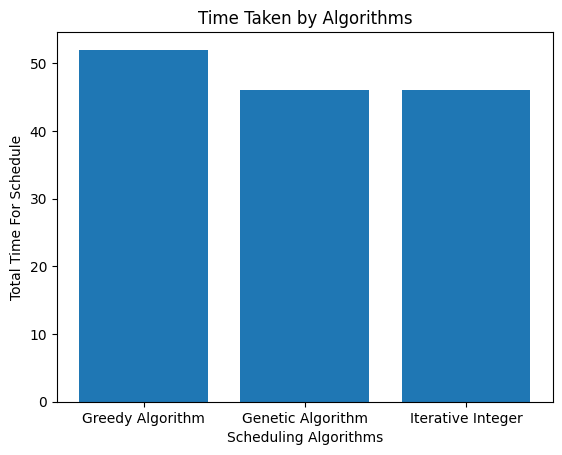

In [36]:
import matplotlib.pyplot as plt

plt.bar(['Greedy Algorithm', 'Genetic Algorithm', 'Iterative Integer'], [greedy_time, genetic_time, ip_time])

plt.title('Time Taken by Algorithms')
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Total Time For Schedule')

plt.show()

## Algorithm Accuracy

In [37]:
def calculate_accuracy(algo_time, ip_time):
    return (algo_time - ip_time) / ip_time * 100

print('Greedy Algorithm Accuracy : {:.2f}%'.format(100 - calculate_accuracy(greedy_time, ip_time)))

print('Genetic Algorithm Accuracy : {:.2f}%'.format(100 - calculate_accuracy(genetic_time, ip_time)))

Greedy Algorithm Accuracy : 86.96%
Genetic Algorithm Accuracy : 100.00%
